# 1) Load dependencies, set session parameters, and load the MNIST data

In [1]:
## Basic PyTorch functionality
import torch
from torch import nn
from torch.utils.data import DataLoader

## CPU data structures
import pandas as pd

## Public datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

## Classical ML-frameworks
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Plotting
import matplotlib.pyplot as plt

## Custom modules
import jm_pytorch_tutorials as jpt
from jm_pytorch_tutorials.models import MLP, CNN, SklearnModelWrapper

In [2]:
# Hyperparameters for session
batch_size = 64
device = jpt.utils.get_device()
print(f"Using device: {device}")

Using device: mps


In [3]:

# Dataset downloading, normalization, adding to train/test splits
download = False
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(root="./data", train=True, transform=transform, download=download)
test_dataset = MNIST(root="./data", train=False, transform=transform, download=download)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

X_test_tensor = torch.stack([x[0] for x in test_dataset]).to(device)

# 2) Training/Testing PyTorch and Sklearn models

In [4]:
## PyTorch Train/Test

# Instantiate Pytorch models
torch_models = {
    "MLP": MLP(input_shape=(1, 28, 28), hidden_dims=[512], num_classes=10),
    "CNN": CNN(input_shape=(1, 28, 28), conv_channels=[32, 64], fc_dims=[128], num_classes=10),
}

# Loop through to train/test all Pytorch models
for name, model in torch_models.items():
    # Train each Pytorch model instance
    jpt.train.train_torch_model(model, train_loader, epochs=5,
                optimizer_class=torch.optim.Adam,
                learning_rate=0.001,
                criterion=nn.CrossEntropyLoss())
    # Evaluate each trained Pytorch model on a test dataset
    print(f"Testing {name}")
    jpt.test.evaluate_torch_model(model, test_loader, 
                                  class_names=None, save_to_model=True)

Training model: MLP
Trainable parameters: 407,050
Epoch 1/5: Loss = 245.4039 | Time = 2.42s
Epoch 2/5: Loss = 94.5838 | Time = 2.27s
Epoch 3/5: Loss = 61.7240 | Time = 2.44s
Epoch 4/5: Loss = 41.7898 | Time = 2.38s
Epoch 5/5: Loss = 31.2698 | Time = 2.25s
Total training time: 11.76s
Testing MLP
Evaluating model: MLP

Evaluation Accuracy: 97.73% | Time: 0.32s
Per-Class ROC AUC and PR AUC:
  class_0: ROC AUC = 1.000, PR AUC = 0.999
  class_1: ROC AUC = 1.000, PR AUC = 0.999
  class_2: ROC AUC = 1.000, PR AUC = 0.998
  class_3: ROC AUC = 1.000, PR AUC = 0.998
  class_4: ROC AUC = 1.000, PR AUC = 0.998
  class_5: ROC AUC = 1.000, PR AUC = 0.998
  class_6: ROC AUC = 1.000, PR AUC = 0.998
  class_7: ROC AUC = 1.000, PR AUC = 0.997
  class_8: ROC AUC = 1.000, PR AUC = 0.996
  class_9: ROC AUC = 0.999, PR AUC = 0.996

Macro ROC AUC: 1.000 | Macro PR AUC: 0.998
Training model: CNN
Trainable parameters: 421,642
Epoch 1/5: Loss = 165.5443 | Time = 5.95s
Epoch 2/5: Loss = 46.3177 | Time = 5.85s
Ep

In [5]:
## Sklearn Fit/Eval

# Flatten images and move to CPU
X_train = train_dataset.data.view(-1, 28*28).numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.view(-1, 28*28).numpy()
y_test = test_dataset.targets.numpy()

# Subsample to speed up training
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

# Instantiate wrapped Sklearn models
sklearn_models = {
    "SVM": SklearnModelWrapper(SVC(kernel='linear', probability=True)),
    "RF": SklearnModelWrapper(RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    "NB": SklearnModelWrapper(GaussianNB())
}

# Loop through Sklearn models to fit/eval
for name, model in sklearn_models.items():
    model.fit(X_train_small, y_train_small)
    metrics = model.evaluate(X_test, y_test)

Training SVC
Training time: 8.77s
Evaluating SVC
Evaluating model: SVC
Training RandomForestClassifier
Training time: 0.25s
Evaluating RandomForestClassifier
Evaluating model: RandomForestClassifier
Training GaussianNB
Training time: 0.04s
Evaluating GaussianNB
Evaluating model: GaussianNB


# 3) Organizing/visualizing eval metrics

In [6]:
## Consolidate models and evaluation metrics
all_models = {** sklearn_models, **torch_models}
results = []

for name, model in all_models.items():
    results.append(model.eval_metrics)

In [7]:
## Structure results into a DataFrame if you'd like
df = pd.DataFrame([{
    "Model": r["label"],
    "Accuracy": r["accuracy"],
    "AUROC": r["auroc"],
    "AUPRC": r["auprc"],
    "Train Time (s)": r["train_time"],
    "Inference Time (s)": r["inference_time"]
} for r in results])
print(df.round(4))

                    Model  Accuracy   AUROC   AUPRC  Train Time (s)  \
0                     SVC    0.9203  0.9943  0.9672          8.7710   
1  RandomForestClassifier    0.9482  0.9972  0.9833          0.2514   
2              GaussianNB    0.5738  0.9179  0.6094          0.0365   
3                     MLP   97.7300  0.9997  0.9978         11.7596   
4                     CNN   99.0600  0.9999  0.9994         29.8322   

   Inference Time (s)  
0              2.7490  
1              0.0332  
2              0.1296  
3              0.3225  
4              0.4369  


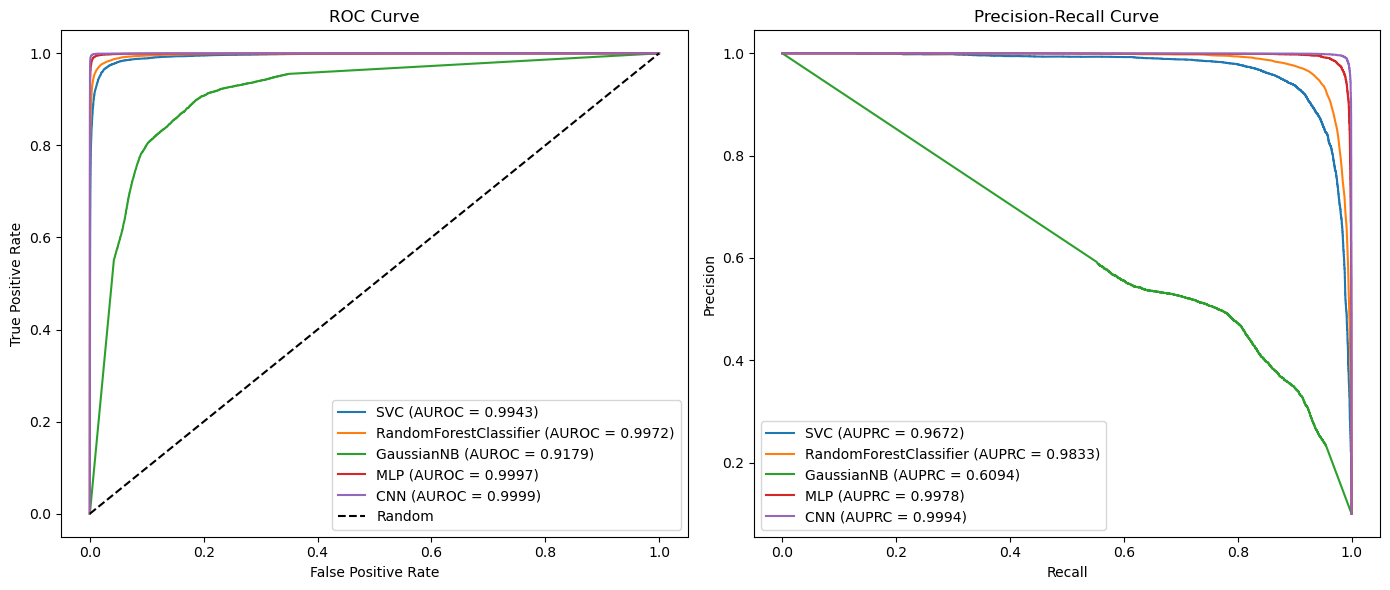

In [8]:
## Plot ROC and P/R curves
jpt.plot_roc_pr_curves(results)

# 4) Model interpretability

Feature saliency for MLP


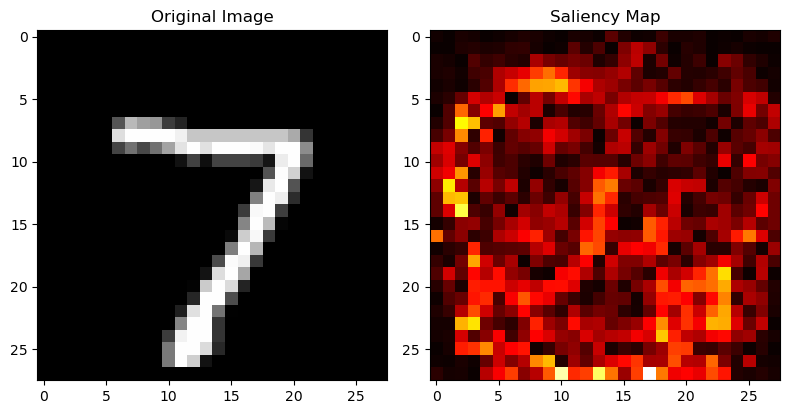

Feature saliency for CNN


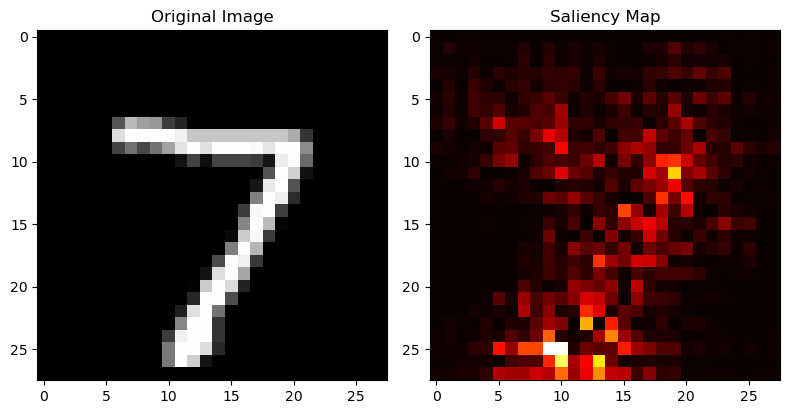

In [9]:
## PyTorch models - input feature saliency

# Pick a test image
x, y = test_dataset[0]

for name, model in torch_models.items():
    print(f"Feature saliency for {name}")
    sal = jpt.compute_saliency(model, x, y)
    jpt.show_saliency_map(x, sal)

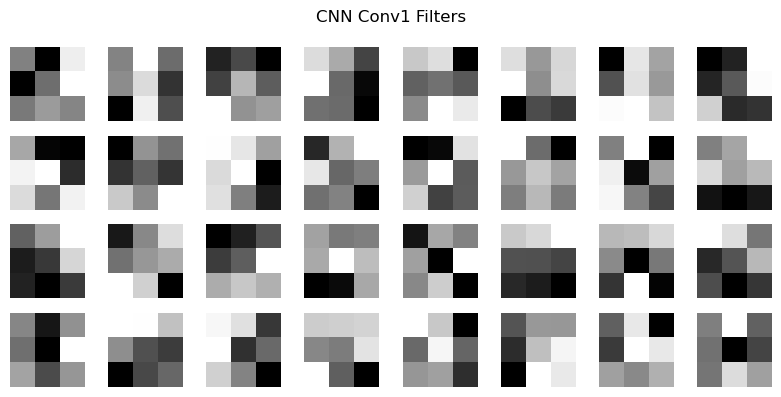

In [10]:
## Visualize the learned filters from a chosen layer of the CNN

cnn = torch_models['CNN']
layer_name = "conv.0"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title="CNN Conv1 Filters")


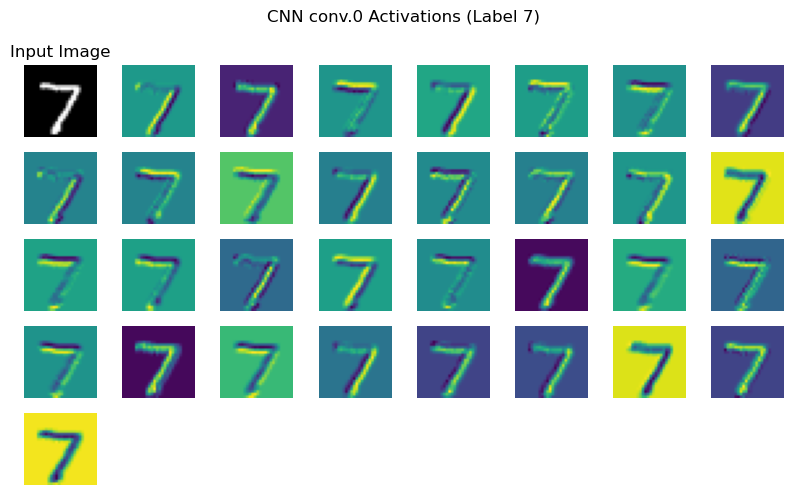

In [11]:
## Visualize the activation patterns from the learned filters from a chosen layer of a CNN on an input image.

cnn = torch_models['CNN']
layer_name='conv.0'

# Choose a test image
img, label = test_dataset[0]

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} Activations (Label {label})")


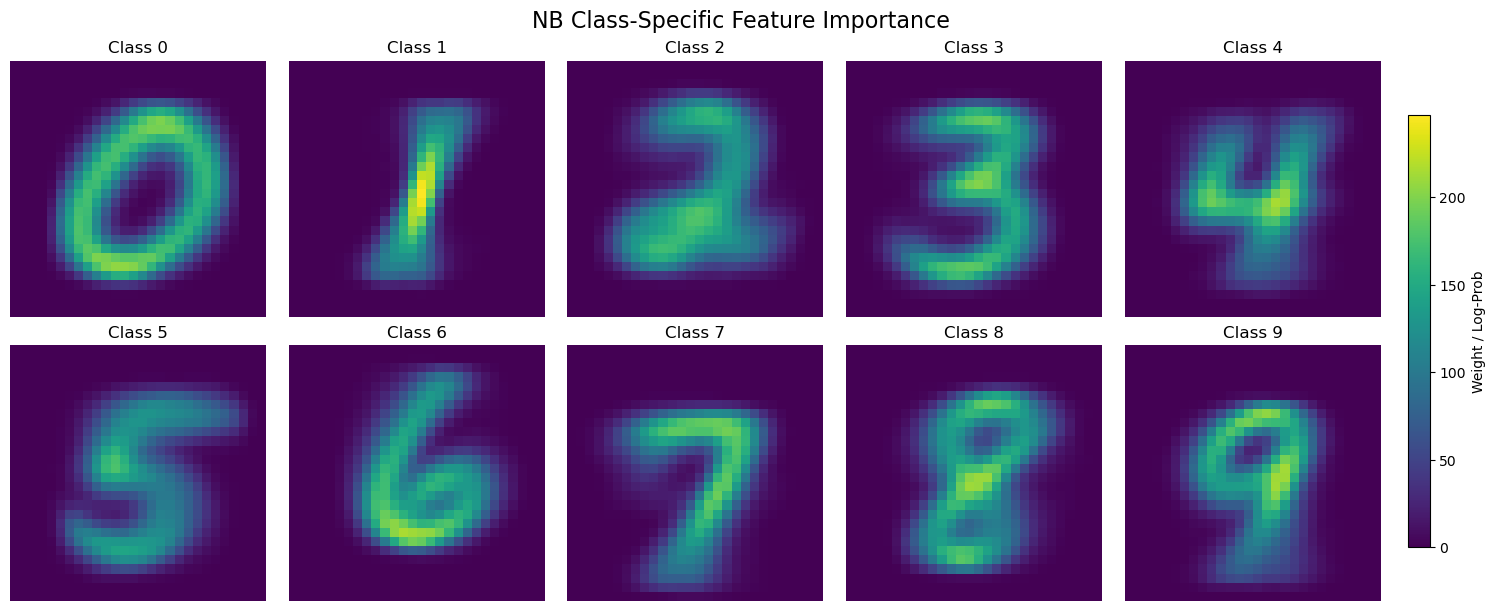

In [12]:
## Class by class feature importances for Naive Bayes Classifier.
nb = sklearn_models['NB'].model
jpt.plot_classwise_maps(nb, model_type="nb")